In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=False, save_file=False)

2019-10-30 18:19:05,074 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:19:05,076 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:19:05,077 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [6]:
strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

In [7]:
strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

In [8]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

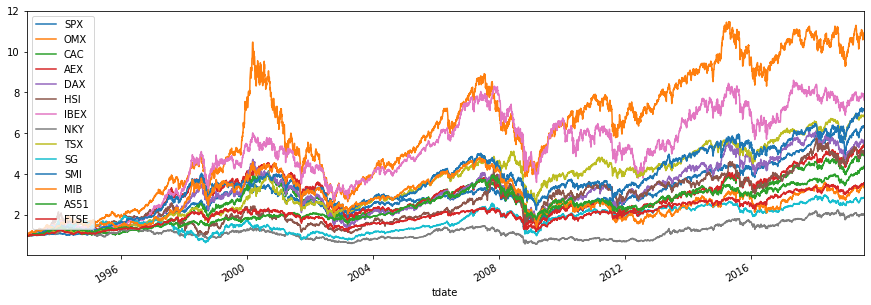

In [9]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

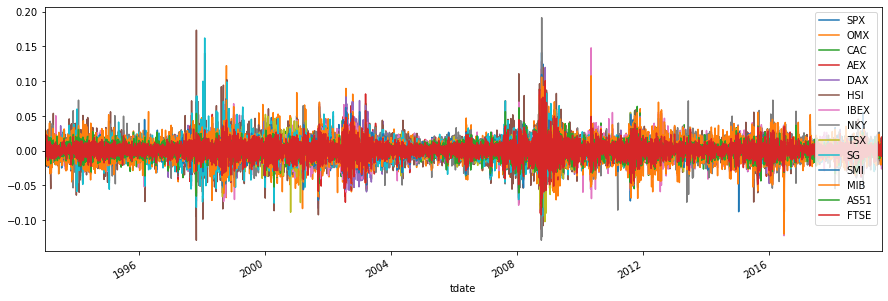

In [10]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [11]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### average return

In [12]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [13]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [14]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [15]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average 와 주가 차이

In [16]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [17]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [18]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [19]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EPM_PAST.png">

<img src="./result/EPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [20]:
one_week = 5
one_month = 20

In [21]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [22]:
df_index_y_binary = df_index_rank > 7.5
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [23]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [24]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_cum_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_vol, on=['tdate', 'ticker'])

In [25]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [27]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [28]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.69266	valid_1's binary_logloss: 0.69266
[20]	training's binary_logloss: 0.69224	valid_1's binary_logloss: 0.69224
[30]	training's binary_logloss: 0.691871	valid_1's binary_logloss: 0.691871
[40]	training's binary_logloss: 0.691535	valid_1's binary_logloss: 0.691535
[50]	training's binary_logloss: 0.691236	valid_1's binary_logloss: 0.691236
[60]	training's binary_logloss: 0.690953	valid_1's binary_logloss: 0.690953
[70]	training's binary_logloss: 0.69069	valid_1's binary_logloss: 0.69069
[80]	training's binary_logloss: 0.690442	valid_1's binary_logloss: 0.690442
[90]	training's binary_logloss: 0.690223	valid_1's binary_logloss: 0.690223
[100]	training's binary_logloss: 0.690005	valid_1's binary_logloss: 0.690005
[110]	training's binary_logloss: 0.689788	valid_1's binary_logloss: 0.689788
[120]	training's binary_logloss: 0.689582	valid_1's binary_logloss: 0.689582
[130]	training's binary_loglo

In [29]:
test_pred = model.predict(df_test_x.values)

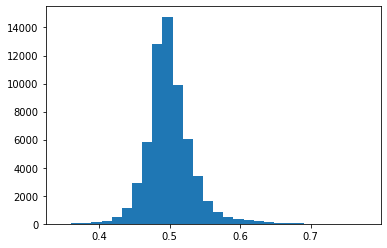

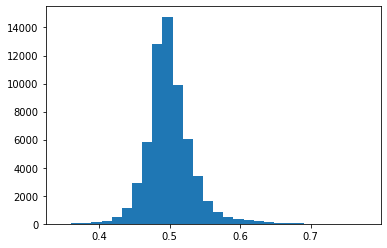

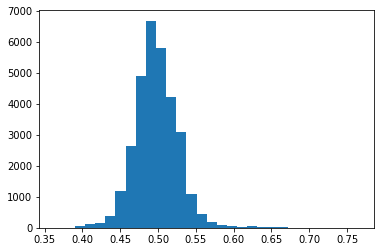

In [30]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [31]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [33]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [34]:
df_index_sub = df_index.loc['1994':]

In [35]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [36]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [37]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-30 18:20:26,632 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [38]:
tester = Tester(strategy)

In [39]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [40]:
strategy.set_portfolio_parameter(cs_strategy_type='vol')
strategy.make_portfolio()

2019-10-30 18:20:27,685 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:20:27,686 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:20:27,686 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:20:41,521 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:20:41,522 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 18:20:43,159 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 18:20:43,166 - EPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-30 18:20:44,267 - EPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-30 18:20:44,270 - EPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-30 18:20:44,270 - EPM - INFO - [STEP 5 - 3 - 1] TARGET VOL CONTROL to CS POSITION
2019-10-30 18:20:44,276 - EPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-30 18:20:52,476 - EPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2019-10-30 18

### TRAIN

2019-10-30 18:20:53,798 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:20:53,799 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:20:53,808 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:20:53,817 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


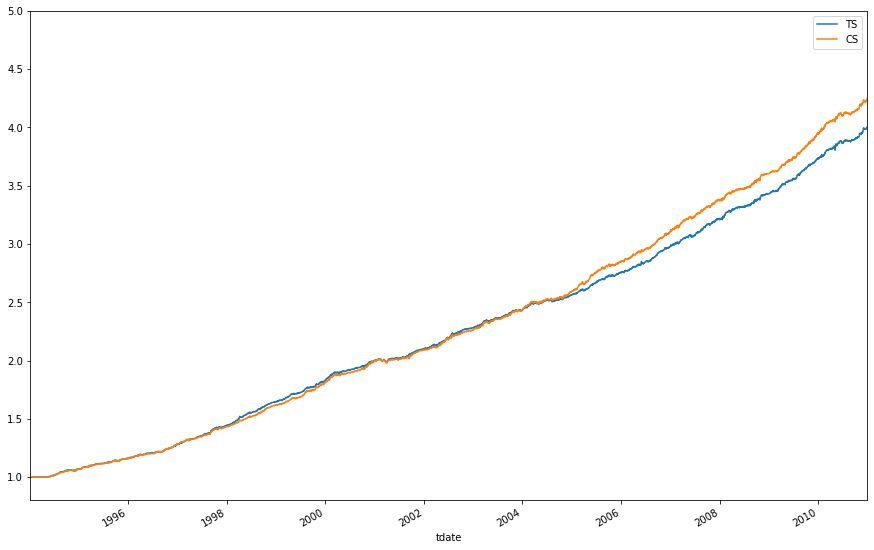

In [41]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-30 19:58:46,768 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:58:46,768 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:58:46,768 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:58:46,768 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:58:46,771 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:58:46,771 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:58:46,771 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:58:46,771 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:58:46,783 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:58:46,783 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:58:46,783 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:58:46,783 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:58:46,792 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:58:46,792 - EPM - INFO - [STEP 7]

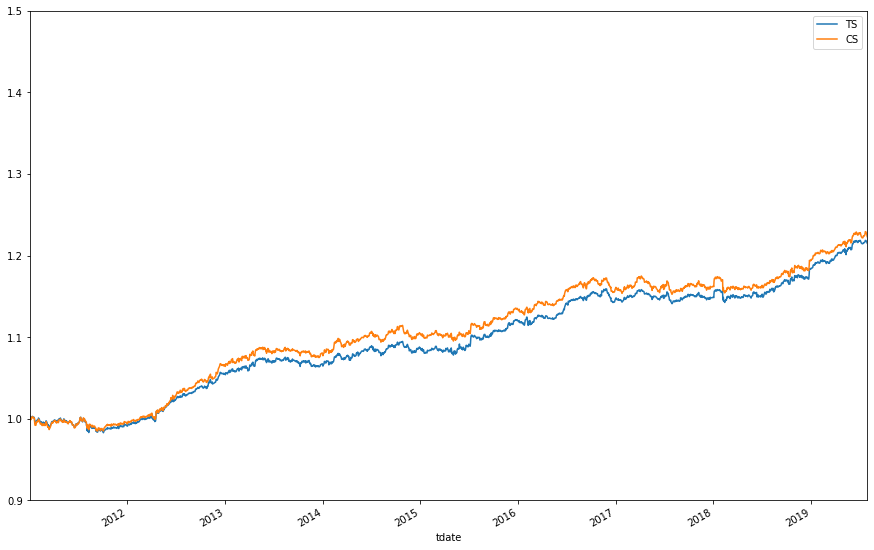

In [74]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [43]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [44]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [45]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [46]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [47]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [48]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [49]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686128	valid_1's binary_logloss: 0.697366
[20]	training's binary_logloss: 0.685419	valid_1's binary_logloss: 0.697028
[30]	training's binary_logloss: 0.684775	valid_1's binary_logloss: 0.696752
[40]	training's binary_logloss: 0.684213	valid_1's binary_logloss: 0.69658
[50]	training's binary_logloss: 0.683713	valid_1's binary_logloss: 0.696417
[60]	training's binary_logloss: 0.683247	valid_1's binary_logloss: 0.696299
[70]	training's binary_logloss: 0.682818	valid_1's binary_logloss: 0.696192
[80]	training's binary_logloss: 0.682432	valid_1's binary_logloss: 0.696092
[90]	training's binary_logloss: 0.682029	valid_1's binary_logloss: 0.695995
[100]	training's binary_logloss: 0.681654	valid_1's binary_logloss: 0.695939
[110]	training's binary_logloss: 0.681312	valid_1's binary_logloss: 0.695905
[120]	training's binary_logloss: 0.680952	valid_1's binary_logloss: 0.695866
[130]	training's binary_

In [50]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([5.0000e+00, 1.6000e+01, 4.2000e+01, 7.1000e+01, 1.6200e+02,
        2.7700e+02, 3.8000e+02, 6.2500e+02, 1.4880e+03, 3.9990e+03,
        8.2530e+03, 1.3164e+04, 1.7314e+04, 1.5590e+04, 1.1280e+04,
        8.1070e+03, 6.2820e+03, 2.9610e+03, 1.1490e+03, 6.6900e+02,
        4.0700e+02, 3.3100e+02, 2.3000e+02, 1.6500e+02, 9.0000e+01,
        5.0000e+01, 2.4000e+01, 3.1000e+01, 1.3000e+01, 9.0000e+00]),
 array([0.331205  , 0.34806335, 0.36492169, 0.38178004, 0.39863839,
        0.41549674, 0.43235509, 0.44921343, 0.46607178, 0.48293013,
        0.49978848, 0.51664682, 0.53350517, 0.55036352, 0.56722187,
        0.58408022, 0.60093856, 0.61779691, 0.63465526, 0.65151361,
        0.66837196, 0.6852303 , 0.70208865, 0.718947  , 0.73580535,
        0.7526637 , 0.76952204, 0.78638039, 0.80323874, 0.82009709,
        0.83695544]),
 <a list of 30 Patch objects>)

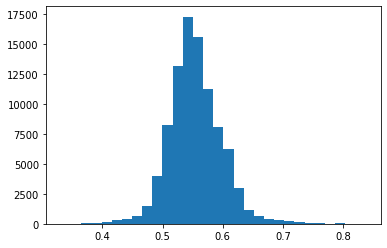

In [51]:
plt.hist(pred2, bins=30)

In [52]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [53]:
strategy2 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=False, save_file=False)
strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'
strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-30 18:20:55,739 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:20:55,739 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:20:55,741 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:20:55,741 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:20:55,742 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:20:55,742 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [54]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='vol')
strategy2.make_portfolio()

2019-10-30 18:20:55,783 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:20:55,783 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:20:55,784 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:20:55,784 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:20:55,785 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:20:55,785 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:20:55,785 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:20:55,785 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:21:09,742 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:21:09,742 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:21:09,743 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 18:21:09,743 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 18:21:11,332 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 18:21:11,332 - EPM - 

### TRAIN

2019-10-30 18:21:22,039 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:21:22,039 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:21:22,040 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:21:22,040 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:21:22,048 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:21:22,048 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:21:22,056 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 18:21:22,056 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


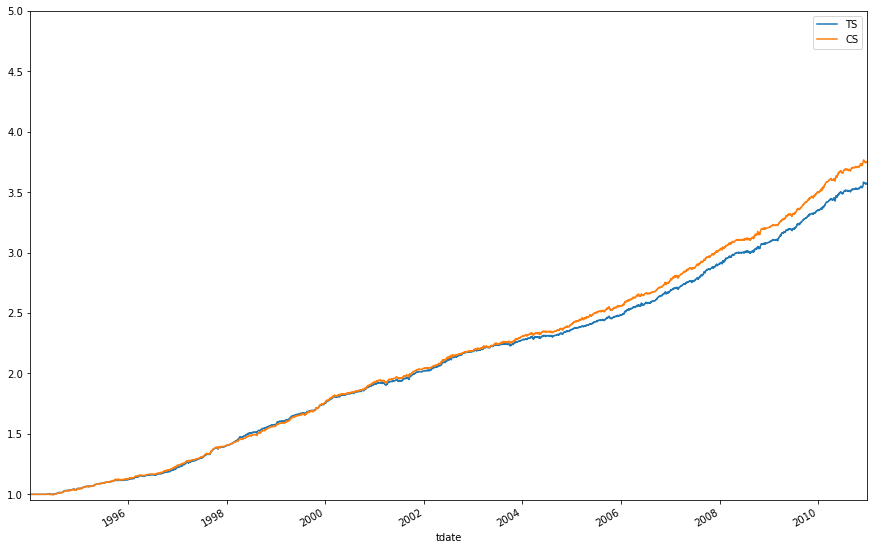

In [55]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-30 19:58:54,141 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:58:54,141 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:58:54,141 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:58:54,141 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:58:54,143 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:58:54,143 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:58:54,143 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:58:54,143 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:58:54,151 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:58:54,151 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:58:54,151 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:58:54,151 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:58:54,161 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:58:54,161 - EPM - INFO - [STEP 7]

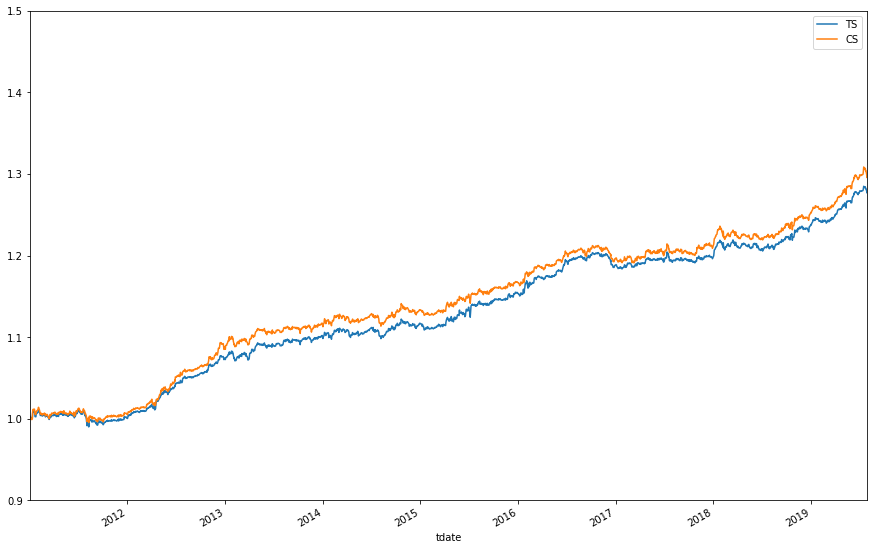

In [75]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 3. Case1을 Rolling으로 실행

In [57]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [58]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [59]:
models = []
train_preds = []
test_preds = []

In [60]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.69266	valid_1's binary_logloss: 0.692894
[20]	training's binary_logloss: 0.69224	valid_1's binary_logloss: 0.6927
[30]	training's binary_logloss: 0.691871	valid_1's binary_logloss: 0.692501
[40]	training's binary_logloss: 0.691535	valid_1's binary_logloss: 0.692354
[50]	training's binary_logloss: 0.691236	valid_1's binary_logloss: 0.692233
[60]	training's binary_logloss: 0.690953	valid_1's binary_logloss: 0.692146
[70]	training's binary_logloss: 0.69069	valid_1's binary_logloss: 0.692065
[80]	training's binary_logloss: 0.690442	valid_1's binary_logloss: 0.692049
[90]	training's binary_logloss: 0.690223	valid_1's binary_logloss: 0.692043
[100]	training's binary_logloss: 0.690005	valid_1's binary_logloss: 0.692021
[110]	training's binary_logloss: 0.689788	valid_1's binary_logloss: 0.691979
[120]	training's binary_logloss: 0.689582	valid_1's binary_logloss: 0.691949
[130]	training's binary_logl

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.69269	valid_1's binary_logloss: 0.692836
[20]	training's binary_logloss: 0.692294	valid_1's binary_logloss: 0.692535
[30]	training's binary_logloss: 0.691948	valid_1's binary_logloss: 0.692261
[40]	training's binary_logloss: 0.691636	valid_1's binary_logloss: 0.692033
[50]	training's binary_logloss: 0.691355	valid_1's binary_logloss: 0.691893
[60]	training's binary_logloss: 0.69109	valid_1's binary_logloss: 0.691762
[70]	training's binary_logloss: 0.690839	valid_1's binary_logloss: 0.691675
[80]	training's binary_logloss: 0.690603	valid_1's binary_logloss: 0.691525
[90]	training's binary_logloss: 0.690386	valid_1's binary_logloss: 0.691443
[100]	training's binary_logloss: 0.690174	valid_1's binary_logloss: 0.691387
[110]	training's binary_logloss: 0.689963	valid_1's binary_logloss: 0.691385
[120]	training's binary_logloss: 0.689755	valid_1's binary_logloss: 0.69137
[130]	training's binary_lo

[80]	training's binary_logloss: 0.690745	valid_1's binary_logloss: 0.692249
[90]	training's binary_logloss: 0.690549	valid_1's binary_logloss: 0.692219
[100]	training's binary_logloss: 0.690354	valid_1's binary_logloss: 0.692203
[110]	training's binary_logloss: 0.690168	valid_1's binary_logloss: 0.692173
[120]	training's binary_logloss: 0.689971	valid_1's binary_logloss: 0.692141
[130]	training's binary_logloss: 0.68979	valid_1's binary_logloss: 0.692123
[140]	training's binary_logloss: 0.6896	valid_1's binary_logloss: 0.692127
[150]	training's binary_logloss: 0.689407	valid_1's binary_logloss: 0.692103
[160]	training's binary_logloss: 0.689226	valid_1's binary_logloss: 0.692095
[170]	training's binary_logloss: 0.689046	valid_1's binary_logloss: 0.692076
[180]	training's binary_logloss: 0.688852	valid_1's binary_logloss: 0.692057
[190]	training's binary_logloss: 0.688655	valid_1's binary_logloss: 0.692042
[200]	training's binary_logloss: 0.68848	valid_1's binary_logloss: 0.692036
[210]

[190]	training's binary_logloss: 0.688996	valid_1's binary_logloss: 0.692233
[200]	training's binary_logloss: 0.68884	valid_1's binary_logloss: 0.692223
[210]	training's binary_logloss: 0.688659	valid_1's binary_logloss: 0.692204
[220]	training's binary_logloss: 0.688507	valid_1's binary_logloss: 0.692178
[230]	training's binary_logloss: 0.688347	valid_1's binary_logloss: 0.692198
[240]	training's binary_logloss: 0.688179	valid_1's binary_logloss: 0.692199
[250]	training's binary_logloss: 0.688023	valid_1's binary_logloss: 0.692244
[260]	training's binary_logloss: 0.687881	valid_1's binary_logloss: 0.692283
[270]	training's binary_logloss: 0.687727	valid_1's binary_logloss: 0.692294
[280]	training's binary_logloss: 0.687578	valid_1's binary_logloss: 0.692297
[290]	training's binary_logloss: 0.687437	valid_1's binary_logloss: 0.692311
[300]	training's binary_logloss: 0.687299	valid_1's binary_logloss: 0.692318
[310]	training's binary_logloss: 0.687156	valid_1's binary_logloss: 0.692354


[240]	training's binary_logloss: 0.688718	valid_1's binary_logloss: 0.691289
[250]	training's binary_logloss: 0.688572	valid_1's binary_logloss: 0.691287
[260]	training's binary_logloss: 0.688434	valid_1's binary_logloss: 0.691273
[270]	training's binary_logloss: 0.688301	valid_1's binary_logloss: 0.691253
[280]	training's binary_logloss: 0.688181	valid_1's binary_logloss: 0.691297
[290]	training's binary_logloss: 0.688059	valid_1's binary_logloss: 0.691299
[300]	training's binary_logloss: 0.687923	valid_1's binary_logloss: 0.691261
[310]	training's binary_logloss: 0.687799	valid_1's binary_logloss: 0.691225
[320]	training's binary_logloss: 0.687672	valid_1's binary_logloss: 0.691247
[330]	training's binary_logloss: 0.687538	valid_1's binary_logloss: 0.691242
[340]	training's binary_logloss: 0.687405	valid_1's binary_logloss: 0.691239
[350]	training's binary_logloss: 0.687279	valid_1's binary_logloss: 0.691262
[360]	training's binary_logloss: 0.687158	valid_1's binary_logloss: 0.691248

In [61]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([3.000e+00, 1.000e+00, 3.100e+01, 8.200e+01, 1.390e+02, 2.350e+02,
        7.810e+02, 1.878e+03, 5.695e+03, 8.414e+03, 5.872e+03, 3.932e+03,
        2.299e+03, 9.600e+02, 4.070e+02, 2.000e+02, 9.800e+01, 7.800e+01,
        3.800e+01, 4.400e+01, 2.200e+01, 2.900e+01, 2.500e+01, 7.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 9.000e+00]),
 array([0.36296804, 0.37639332, 0.38981861, 0.4032439 , 0.41666918,
        0.43009447, 0.44351975, 0.45694504, 0.47037033, 0.48379561,
        0.4972209 , 0.51064618, 0.52407147, 0.53749676, 0.55092204,
        0.56434733, 0.57777261, 0.5911979 , 0.60462319, 0.61804847,
        0.63147376, 0.64489904, 0.65832433, 0.67174962, 0.6851749 ,
        0.69860019, 0.71202547, 0.72545076, 0.73887604, 0.75230133,
        0.76572662]),
 <a list of 30 Patch objects>)

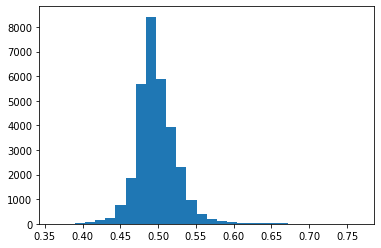

In [62]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [63]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [64]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)
strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'
strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-30 18:21:37,062 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:21:37,062 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:21:37,062 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:21:37,064 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:21:37,064 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:21:37,064 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:21:37,065 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:21:37,065 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:21:37,065 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [65]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='vol')
strategy3.make_portfolio()

2019-10-30 18:21:37,106 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:21:37,106 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:21:37,106 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:21:37,108 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:21:37,108 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:21:37,108 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:21:37,109 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:21:37,109 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:21:37,109 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:21:37,110 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:21:37,110 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:21:37,110 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:21:50,997 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:21:50,997 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:21:50,997 - EPM -

2019-10-30 19:59:04,052 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:59:04,052 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:59:04,052 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:59:04,052 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:59:04,054 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:59:04,054 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:59:04,054 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:59:04,054 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:59:04,062 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:59:04,062 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:59:04,062 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:59:04,062 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:59:04,071 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:59:04,071 - EPM - INFO - [STEP 7]

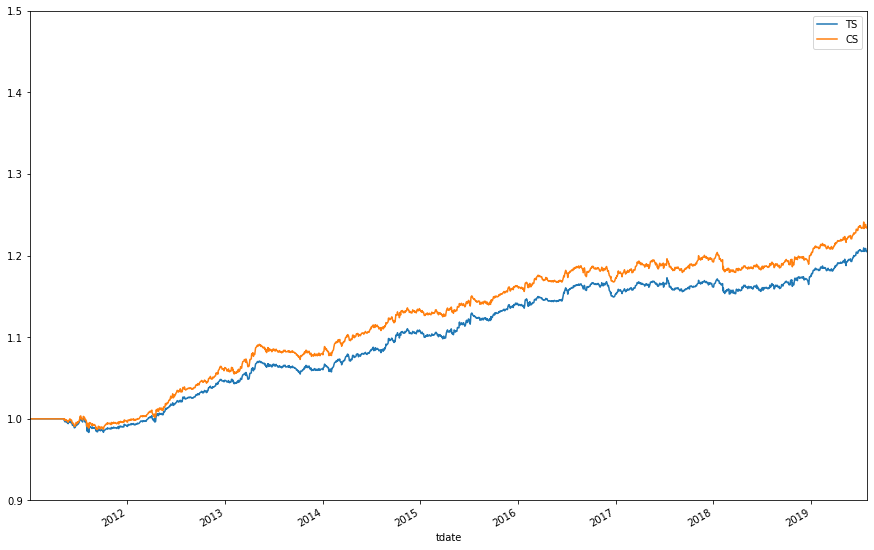

In [76]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 4. CASE 2를 ROLLING으로 실행

In [67]:
models = []
train_preds = []
test_preds = []

In [68]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686128	valid_1's binary_logloss: 0.69904
[20]	training's binary_logloss: 0.685419	valid_1's binary_logloss: 0.698965
[30]	training's binary_logloss: 0.684775	valid_1's binary_logloss: 0.699039
[40]	training's binary_logloss: 0.684213	valid_1's binary_logloss: 0.699275
[50]	training's binary_logloss: 0.683713	valid_1's binary_logloss: 0.699543
[60]	training's binary_logloss: 0.683247	valid_1's binary_logloss: 0.699837
[70]	training's binary_logloss: 0.682818	valid_1's binary_logloss: 0.700154
[80]	training's binary_logloss: 0.682432	valid_1's binary_logloss: 0.700353
[90]	training's binary_logloss: 0.682029	valid_1's binary_logloss: 0.700697
[100]	training's binary_logloss: 0.681654	valid_1's binary_logloss: 0.701147
[110]	training's binary_logloss: 0.681312	valid_1's binary_logloss: 0.701531
[120]	training's binary_logloss: 0.680952	valid_1's binary_logloss: 0.701791
[130]	training's binary_

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686164	valid_1's binary_logloss: 0.698631
[20]	training's binary_logloss: 0.685461	valid_1's binary_logloss: 0.698197
[30]	training's binary_logloss: 0.684839	valid_1's binary_logloss: 0.697814
[40]	training's binary_logloss: 0.684277	valid_1's binary_logloss: 0.697546
[50]	training's binary_logloss: 0.683778	valid_1's binary_logloss: 0.697328
[60]	training's binary_logloss: 0.683344	valid_1's binary_logloss: 0.697249
[70]	training's binary_logloss: 0.682924	valid_1's binary_logloss: 0.697094
[80]	training's binary_logloss: 0.682535	valid_1's binary_logloss: 0.69699
[90]	training's binary_logloss: 0.682178	valid_1's binary_logloss: 0.69699
[100]	training's binary_logloss: 0.681834	valid_1's binary_logloss: 0.696957
[110]	training's binary_logloss: 0.681512	valid_1's binary_logloss: 0.697039
[120]	training's binary_logloss: 0.681202	valid_1's binary_logloss: 0.696906
[130]	training's binary_l

[120]	training's binary_logloss: 0.681594	valid_1's binary_logloss: 0.698324
[130]	training's binary_logloss: 0.681336	valid_1's binary_logloss: 0.698379
[140]	training's binary_logloss: 0.681081	valid_1's binary_logloss: 0.698334
[150]	training's binary_logloss: 0.680849	valid_1's binary_logloss: 0.698348
[160]	training's binary_logloss: 0.680619	valid_1's binary_logloss: 0.698437
[170]	training's binary_logloss: 0.680394	valid_1's binary_logloss: 0.698469
[180]	training's binary_logloss: 0.680202	valid_1's binary_logloss: 0.698523
[190]	training's binary_logloss: 0.679979	valid_1's binary_logloss: 0.698583
[200]	training's binary_logloss: 0.679732	valid_1's binary_logloss: 0.698603
[210]	training's binary_logloss: 0.679486	valid_1's binary_logloss: 0.698666
[220]	training's binary_logloss: 0.679245	valid_1's binary_logloss: 0.69868
[230]	training's binary_logloss: 0.679019	valid_1's binary_logloss: 0.698659
[240]	training's binary_logloss: 0.678771	valid_1's binary_logloss: 0.698611


[270]	training's binary_logloss: 0.678658	valid_1's binary_logloss: 0.701247
[280]	training's binary_logloss: 0.67843	valid_1's binary_logloss: 0.701292
[290]	training's binary_logloss: 0.678236	valid_1's binary_logloss: 0.701121
[300]	training's binary_logloss: 0.678041	valid_1's binary_logloss: 0.7012
[310]	training's binary_logloss: 0.677844	valid_1's binary_logloss: 0.701199
[320]	training's binary_logloss: 0.677645	valid_1's binary_logloss: 0.701258
[330]	training's binary_logloss: 0.67745	valid_1's binary_logloss: 0.701244
[340]	training's binary_logloss: 0.677232	valid_1's binary_logloss: 0.701254
[350]	training's binary_logloss: 0.677025	valid_1's binary_logloss: 0.701313
[360]	training's binary_logloss: 0.67683	valid_1's binary_logloss: 0.701384
[370]	training's binary_logloss: 0.676619	valid_1's binary_logloss: 0.701426
[380]	training's binary_logloss: 0.676433	valid_1's binary_logloss: 0.701501
[390]	training's binary_logloss: 0.676221	valid_1's binary_logloss: 0.70144
[400]

In [69]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [70]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [71]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'
strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-30 18:22:03,768 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:22:03,768 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:22:03,768 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:22:03,768 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:22:03,771 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:22:03,771 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:22:03,771 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:22:03,771 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:22:03,772 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:22:03,772 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:22:03,772 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:22:03,772 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [72]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='vol')
strategy4.make_portfolio()

2019-10-30 18:22:03,820 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:22:03,820 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:22:03,820 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:22:03,820 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:22:03,821 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:22:03,821 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:22:03,821 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:22:03,821 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:22:03,823 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:22:03,823 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:22:03,823 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:22:03,823 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:22:03,824 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:22:03,824 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:22:03,824 - EPM - INFO -

2019-10-30 19:59:08,483 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:59:08,483 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:59:08,483 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:59:08,483 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 19:59:08,485 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:59:08,485 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:59:08,485 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:59:08,485 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 19:59:08,493 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:59:08,493 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:59:08,493 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:59:08,493 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 19:59:08,502 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 19:59:08,502 - EPM - INFO - [STEP 7]

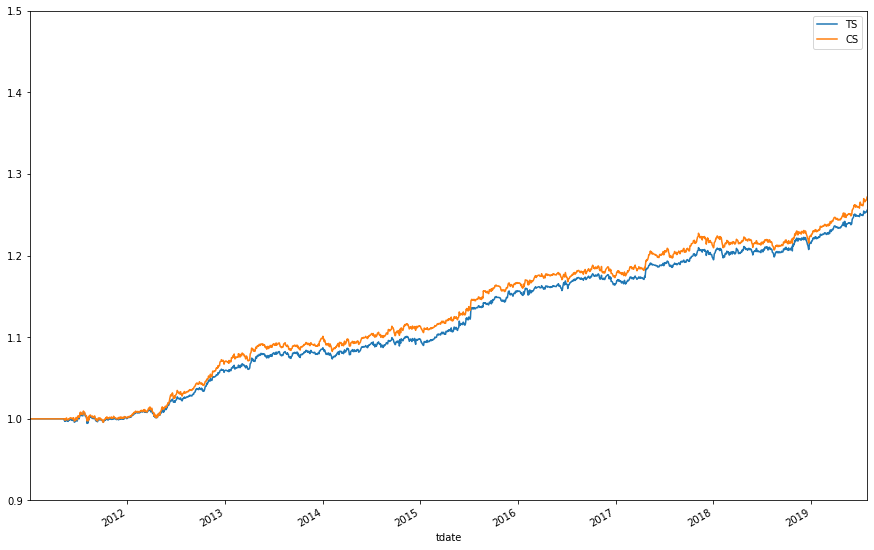

In [77]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))